In [95]:
import os
from IPython.display import HTML
from matplotlib.animation import FuncAnimation, PillowWriter
from numpy import newaxis as na
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
from py_wake import NOJ, NOJLocal
from py_wake.examples.data.ParqueFicticio import ParqueFicticioSite, ParqueFicticio_path
from py_wake.examples.data.dtu10mw._dtu10mw import DTU10MW
from py_wake.examples.data.hornsrev1 import Hornsrev1Site, Hornsrev1WRFSite, V80
from py_wake.examples.data.iea37 import IEA37Site
from py_wake.flow_map import XYGrid
from py_wake.site import UniformSite, UniformWeibullSite, WaspGridSite, XRSite
from py_wake.site.distance import StraightDistance
from py_wake.site.shear import PowerShear
from py_wake.utils import layouts
from py_wake.utils import weibull
from py_wake.utils.maps import dk_coast
from py_wake.utils.plotting import setup_plot
from py_wake.utils.functions import mean_deg
import xarray as xr
xr.set_options(display_expand_data=True);

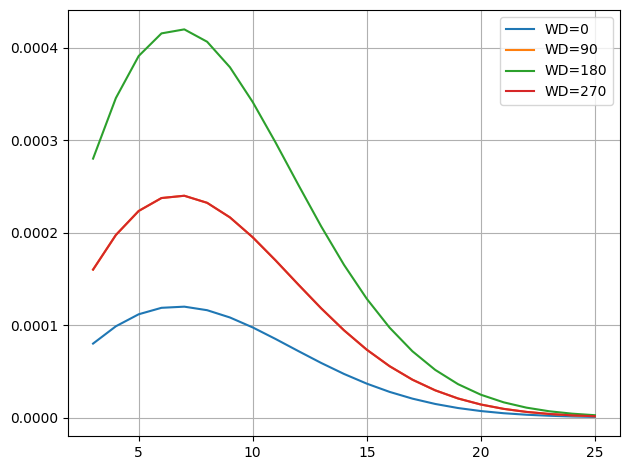

In [96]:

# Dummy offshore site object
wd = np.arange(0, 360, 30)
A = np.full_like(wd, 9.5, dtype=float) # Weibull scale parameter
k = np.full_like(wd, 2.0, dtype=float) # Weibull shape parameter
p_wd = np.array([0.04, 0.05, 0.06, 0.08, 0.10, 0.12,0.14, 0.14, 0.10, 0.08, 0.05, 0.04], dtype=float) # sector frequencies (defines wind direction)
#p_wd /= p_wd.sum()

siteABD = UniformWeibullSite(p_wd=p_wd, a=A, k=k, ti=0.08) # Create uniform weibull site


sim_res = NOJ(siteABD, DTU10MW())([0],[0])[['WS','P']]
sim_res

for P_ws in sim_res.P[::90]:
    P_ws.plot(label=f'WD={P_ws.wd.item()}')
setup_plot()


In [97]:
#Wake model object
wt = DTU10MW()
wake_model = NOJ(siteABD, wt) # Define Wake model
ws = np.arange(3, 26, 1)

Name:		V80	3.35MW	DTU10MW
Diameter[m]	80.0	130.0	178.3
Hubheigt[m]	70.0	110.0	119.0


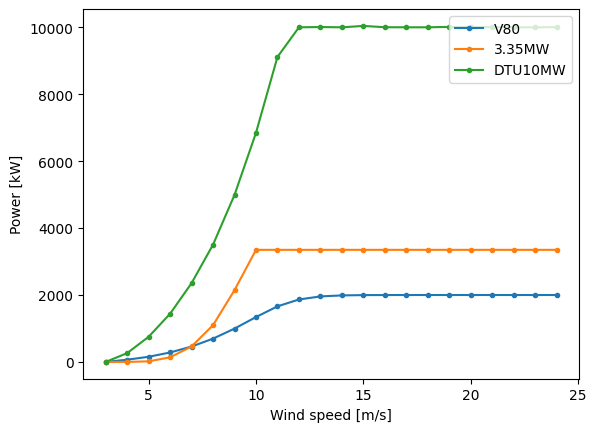

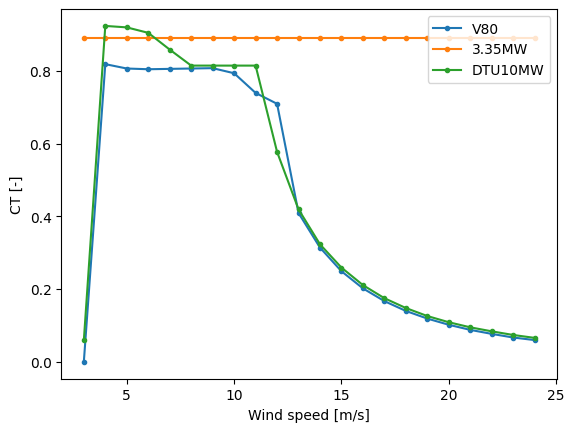

In [98]:
#Wind turbine Object
#Import basic packages
import os
import numpy as np
import matplotlib.pyplot as plt

#Import Built in turbines
from py_wake.wind_turbines import WindTurbine, WindTurbines
from py_wake.examples.data.hornsrev1 import V80
from py_wake.examples.data.iea37 import IEA37_WindTurbines, IEA37Site
from py_wake.examples.data.dtu10mw import DTU10MW

v80 = V80()
iea37 = IEA37_WindTurbines()
dtu10mw = DTU10MW()

#Collect multiple turbine types into single object
wts = WindTurbines.from_WindTurbine_lst([v80,iea37,dtu10mw])
types = wts.types()
print ("Name:\t\t%s" % "\t".join(wts.name(types)))
print('Diameter[m]\t%s' % "\t".join(map(str,wts.diameter(type=types))))
print('Hubheigt[m]\t%s' % "\t".join(map(str,wts.hub_height(type=types))))

#Plot turbine power against wind speed
ws = np.arange(3,25)
plt.xlabel('Wind speed [m/s]')
plt.ylabel('Power [kW]')

for t in types:
    plt.plot(ws, wts.power(ws, type=t)*1e-3,'.-', label=wts.name(t))
plt.legend(loc=1)


#Plot CT for turbines
plt.figure()
plt.xlabel('Wind speed [m/s]')
plt.ylabel('CT [-]')

for t in types:
    plt.plot(ws, wts.ct(ws, type=t),'.-', label=wts.name(t))
plt.legend(loc=1)

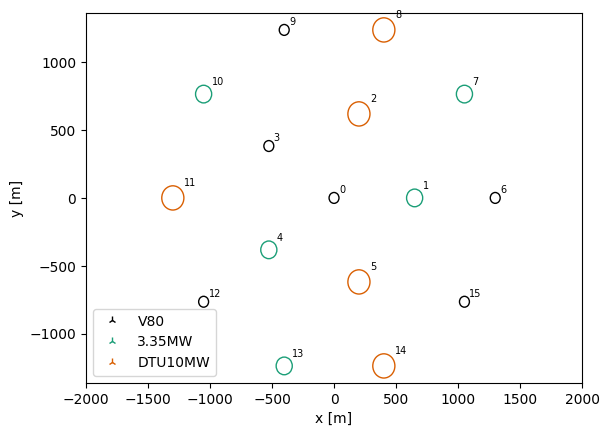

In [99]:
#plot turbines on example site
s = IEA37Site(16)
x,y = s.initial_position.T

plt.figure()
wts.plot_xy(x,y,types=np.arange(len(x))%len(types))
plt.xlim(-2000,2000)
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.legend()

In [100]:
#import all wake deficit models available in PyWake
import numpy as np
import matplotlib.pyplot as plt
import os
import py_wake

from py_wake.examples.data.hornsrev1 import V80, Hornsrev1Site

from py_wake.superposition_models import LinearSum

from py_wake.wind_farm_models import All2AllIterative
from py_wake.deficit_models import NOJDeficit, SelfSimilarityDeficit

site = Hornsrev1Site()
windTurbines = DTU10MW()

from py_wake import NOJ
from py_wake import BastankhahGaussian



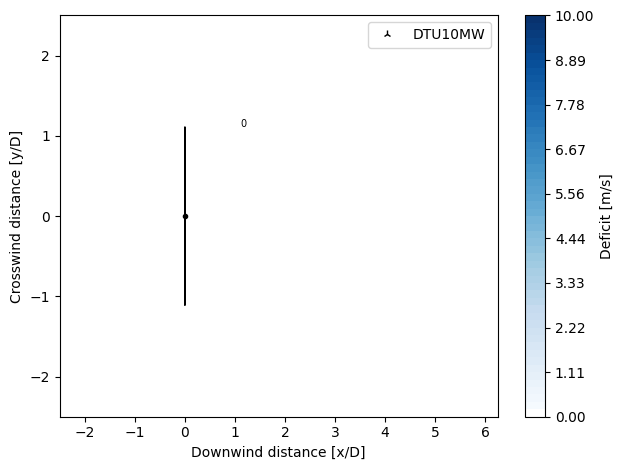

In [101]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from py_wake.deficit_models.deficit_model import WakeDeficitModel, BlockageDeficitModel
from py_wake.deficit_models.no_wake import NoWakeDeficit
from py_wake.site._site import UniformSite
from py_wake.flow_map import XYGrid
from py_wake.turbulence_models import CrespoHernandez
from py_wake.utils.plotting import setup_plot
from py_wake.deficit_models import BastankhahGaussianDeficit

#turbine diameter
D = 80 #m

def get_flow_map(model=None, grid=XYGrid(x=np.linspace(-200, 500, 200), y=np.linspace(-200, 200, 200), h=119),
                 turbulenceModel=CrespoHernandez()):
    blockage_deficitModel = [None, model][isinstance(model, BlockageDeficitModel)]
    wake_deficitModel = [NoWakeDeficit(), model][isinstance(model, WakeDeficitModel)]
    wfm = All2AllIterative(UniformSite(), DTU10MW(), wake_deficitModel=wake_deficitModel, blockage_deficitModel=blockage_deficitModel,
                           turbulenceModel=turbulenceModel)
    return wfm(x=[0], y=[0], wd=270, ws=10, yaw=0).flow_map(grid)

def plot_deficit_map(model, cmap='Blues', levels=np.linspace(0, 10, 55)):
    fm = get_flow_map(model)
    fm.plot(fm.ws - fm.WS_eff, clabel='Deficit [m/s]', levels=levels, cmap=cmap, normalize_with=D)
    setup_plot(grid=False, ylabel="Crosswind distance [y/D]", xlabel= "Downwind distance [x/D]",
               xlim=[fm.x.min()/D, fm.x.max()/D], ylim=[fm.y.min()/D, fm.y.max()/D], axis='auto')

def plot_wake_deficit_map(model):
    cmap = np.r_[[[1,1,1,1],[1,1,1,1]],cm.Blues(np.linspace(-0,1,128))] # ensure zero deficit is white
    plot_deficit_map(model,cmap=ListedColormap(cmap))


plot_wake_deficit_map(BastankhahGaussianDeficit())


Text(0, 0.5, 'y [m]')

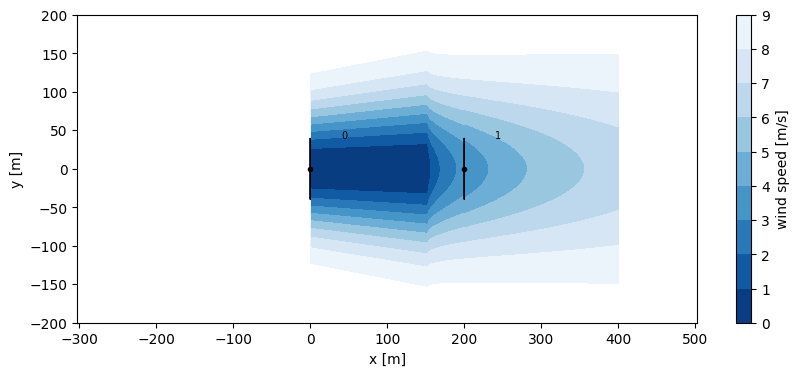

In [102]:
import numpy as np
import matplotlib.pyplot as plt

from py_wake.literature.gaussian_models import Bastankhah_PorteAgel_2014
from py_wake.literature.gaussian_models import Zong_PorteAgel_2020
from py_wake.turbulence_models import CrespoHernandez
from py_wake.examples.data.hornsrev1 import V80, Hornsrev1Site

site = Hornsrev1Site()
windTurbines = V80()

from py_wake.superposition_models import SquaredSum

squared_sum = Bastankhah_PorteAgel_2014(site, windTurbines, k=0.0324555, superpositionModel=SquaredSum())
plt.figure(figsize=(10,4))
squared_sum([0,200],[0,0],wd=270,ws=10).flow_map().plot_wake_map(levels=np.arange(0,10))
plt.xlabel('x [m]')
plt.ylabel('y [m]')